In [75]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor

In [76]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [77]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v4.db')

In [90]:
    cur = con.cursor()

    df = pd.read_sql('''
    select calls_for_service.analysis_neighborhoods as neighborhood
, calls_for_service.call_number
, calls_for_service.incident_number
, floating_catchment_output.[index]
, floating_catchment_output.zone_idx
, floating_catchment_output.accessibility_score
, floating_catchment_output.scenario_name
, calls_for_service.on_scene_dttm
, calls_for_service.response_dttm  
, fire_stations.facility_id
from floating_catchment_output
inner join zone_idx_to_incident on 
zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx
inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number
left join Truck_Engine_Fire_Station as tfs on tfs.unit = calls_for_service.unit_id
left join fire_stations on fire_stations.facility_id = tfs.facility_id
where calls_for_service.unit_type in ('TRUCK', 'ENGINE')
and scenario_name = 'baseline';''',con = con) 

In [91]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 
df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

df = df[df['dayflag'].notna()]
df = df[df['day_of_week'].notna()]
df = df[df['facility_id'].notna()]

In [92]:
#rool up accessibility and minutes to zone
df_ag = df.groupby(["zone_idx","facility_id", "day_of_week", "dayflag"], as_index=False).agg({"accessibility_score":"mean", "minutes":"mean"})
print(len(df_ag))
df_ag.head()

11570


,zone_idx,facility_id,day_of_week,dayflag,accessibility_score,minutes
0,8,696.0,0.0,False,0.000803,4.445833
1,8,696.0,0.0,True,0.000803,13.460000
2,8,696.0,1.0,False,0.000803,4.100000
3,8,696.0,1.0,True,0.000803,5.258333
4,8,696.0,2.0,False,0.000803,4.644444


In [93]:
# hide the warings.
# I mean if it was really important it would just be an error, so blissfully ignore
warnings.filterwarnings('ignore')

# set the training variables
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['zone_idx', "facility_id", 'day_of_week', 'dayflag', 'accessibility_score']

df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)


In [94]:
#copy/paste code:

def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=300, subsample=0.5, colsample_bynode=0.8, min_child_weight=3)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')



XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=3,
               missing=nan, monotone_constraints=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.5,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.20670276829861
md.ytest [5.52833333 2.68333333 3.825      ... 6.525      4.23869048 3.68333333]
Accuracy 58.45839233117161
Accuracy -inf


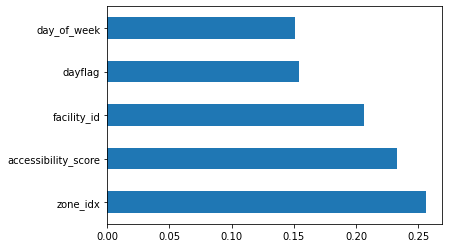

In [95]:
create_model(df_ag)

In [96]:
cur = con.cursor()
df_scenarios = pd.read_sql(('select distinct scenario_name from simulation_floating_catchment_output'), con=con)


In [98]:
prediction_stats = []
predictions = []
compare_errors = []

for i in range(len(df_scenarios)):
    #Get data to predict
    cur = con.cursor()
    scenario_name = df_scenarios["scenario_name"][i]
    day_of_week = 3
    dayFlag = True
    sql = '''select simulation_floating_catchment_output.zone_idx, fire_station_zones.facility_id, accessibility_score 
, ? as day_of_week, ? as dayflag 
from simulation_floating_catchment_output 
inner join (select distinct
floating_catchment_output.zone_idx 
, fire_stations.facility_id
from floating_catchment_output
inner join zone_idx_to_incident on 
zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx
inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number
left join Truck_Engine_Fire_Station as tfs on tfs.unit = calls_for_service.unit_id
left join fire_stations on fire_stations.facility_id = tfs.facility_id
where calls_for_service.unit_type in ('TRUCK', 'ENGINE')
and scenario_name = 'baseline') as fire_station_zones 
    on fire_station_zones.zone_idx = simulation_floating_catchment_output.zone_idx
where scenario_name = ?'''
    df_to_predict = pd.read_sql((sql), con=con,params=[day_of_week, dayFlag, scenario_name])
    #assumptions
    df_to_predict["dayflag"] = dayFlag
    df_to_predict["day_of_week"] = day_of_week
    print("Predicting: " + scenario_name + ", records:" + str(df_to_predict.count()))
    
    prediction = df_ag.XGB.predict(df_to_predict[["zone_idx", "facility_id", "accessibility_score", "day_of_week", "dayflag"]])
    print(len(prediction))
    df_to_predict['predicted_minutes'] = prediction.copy()

    compare_error = df_ag.merge(df_to_predict, how="inner", on=["zone_idx", "day_of_week","dayflag"])

    compare_error["minutes_delta"] = compare_error["minutes"] - compare_error["predicted_minutes"]
    compare_error["accessibility_delta"] = (compare_error["accessibility_score_x"] - compare_error["accessibility_score_y"])
    compare_error['scenario_name'] = scenario_name
    
    compare_errors.append(compare_error.copy())
    sq_error_sum = np.sum(np.square(np.array(compare_error["minutes"]) - np.array(compare_error["predicted_minutes"])))
    sq_error_mean = np.sum(np.square(np.average(compare_error["minutes"]) - np.array(compare_error["minutes"])))

    (r, p) = scipy.stats.pearsonr(compare_error["minutes_delta"], compare_error["accessibility_delta"])

    prediction_stats.append((scenario_name, sq_error_sum.copy(), sq_error_mean.copy(), r,p))
    df_to_predict["scenario_name"] = scenario_name
    predictions.append(df_to_predict.copy())
    
    




Predicting: new_station_235, records:zone_idx               2287
facility_id            2244
accessibility_score    2287
day_of_week            2287
dayflag                2287
dtype: int64
2287
Predicting: new_station_177, records:zone_idx               2287
facility_id            2244
accessibility_score    2287
day_of_week            2287
dayflag                2287
dtype: int64
2287
Predicting: new_station_176, records:zone_idx               2287
facility_id            2244
accessibility_score    2287
day_of_week            2287
dayflag                2287
dtype: int64
2287
Predicting: new_station_319, records:zone_idx               2287
facility_id            2244
accessibility_score    2287
day_of_week            2287
dayflag                2287
dtype: int64
2287
Predicting: new_station_274, records:zone_idx               2287
facility_id            2244
accessibility_score    2287
day_of_week            2287
dayflag                2287
dtype: int64
2287
Predicting: new_station_2

In [86]:
print(pd.concat(compare_errors)[['minutes_delta', 'accessibility_delta', 'scenario_name', 'zone_idx']].to_csv('delta_analysis_dayflag_original_parameters.csv'))

None


In [99]:
sts = pd.DataFrame(prediction_stats)
sts = sts.rename(columns={0: "scenario_name", 1: "sq_avg_error", 2:"sq_sum_error", 3:"r_value",4:"p_value"}, errors="raise")

sts.to_csv('prediction_stats.csv')


In [101]:
pd.concat(predictions).to_csv('predictions_facilityId.csv')

In [102]:
df_ag.to_csv('aggregated_facilityId.csv')